# Sample client usage of Filter Pruning Service

#### sample to set up service server
see https://github.com/vuiseng9/nncf/blob/paas/paas/host_paas_image_classification.sh
    

In [1]:
import os, time, random, torch, sys, requests, json
import numpy as np, pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
host_url = 'http://csr-dgx1-03.jf.intel.com:5000/'

In [6]:
url_ready = host_url + 'ready_state'
url_graphviz = host_url + 'get_model_graph_viz'
url_optype = host_url + 'get_node2optype_map'
url_connectivity = host_url + 'get_connectivity_map'
url_prunable = host_url + 'get_prunable_attr'
url_eval_req = host_url + 'sample_eval_req'
url_evaluate = host_url + 'evaluate'

#### Check if service is ready

In [7]:
requests.get(url=url_ready).json()

{'config': '/home/vchua/nemo-prune/nncf/paas/cfg/vgg11_pruning_magnitude.json',
 'method': 'ready_state',
 'msg': 'Environment imgnet initialized',
 'rc': 0}

#### Graph visualization

Note: you can download through browser with this url http://csr-dgx1-03.jf.intel.com:5002/get_model_graph_viz


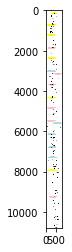

In [8]:
# download a copy of model graph with colorized prunable nodes
print('Note: you can download through browser with this url {}'.format(url_graphviz))

imgpth = 'model_graph.png'
r = requests.get(url_graphviz, allow_redirects=True)
with open(imgpth, 'wb') as fh:
    fh.write(r.content)

plt.imshow(plt.imread(imgpth))

### Graph node to operation type

In [9]:
node_type=requests.get(url=url_optype).json()
node_type

{'0 /nncf_model_input': 'nncf_model_input',
 '1 ResNet/NNCFConv2d[conv1]/conv2d': 'conv2d',
 '10 ResNet/Sequential[layer1]/BasicBlock[0]/__iadd__': '__iadd__',
 '11 ResNet/Sequential[layer1]/BasicBlock[0]/ReLU[relu]/RELU': 'RELU',
 '12 ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv1]/conv2d': 'conv2d',
 '13 ResNet/Sequential[layer1]/BasicBlock[1]/BatchNorm2d[bn1]/batch_norm': 'batch_norm',
 '14 ResNet/Sequential[layer1]/BasicBlock[1]/ReLU[relu]/RELU': 'RELU',
 '15 ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv2]/conv2d': 'conv2d',
 '16 ResNet/Sequential[layer1]/BasicBlock[1]/BatchNorm2d[bn2]/batch_norm': 'batch_norm',
 '17 ResNet/Sequential[layer1]/BasicBlock[1]/__iadd__': '__iadd__',
 '18 ResNet/Sequential[layer1]/BasicBlock[1]/ReLU[relu]/RELU': 'RELU',
 '19 ResNet/Sequential[layer2]/BasicBlock[0]/NNCFConv2d[conv1]/conv2d': 'conv2d',
 '2 ResNet/BatchNorm2d[bn1]/batch_norm': 'batch_norm',
 '20 ResNet/Sequential[layer2]/BasicBlock[0]/BatchNorm2d[bn1]/batch_norm': 'batc

### Mapping of nodes

In [10]:
node_conn = requests.get(url=url_connectivity).json()
# key of the dictionary is source node
# value is a list of destination nodes

# nodetype can be looked up via previous mapping

for i, (src_node, dst_nodes) in enumerate(node_conn.items()):
    print("* ({}) {}".format(node_type[src_node], src_node))
    for dst_node in dst_nodes:
        print("\t-> ({}) {}".format(node_type[dst_node], dst_node))
    print("")
    if i>=5:
        break

* (nncf_model_input) 0 /nncf_model_input
	-> (conv2d) 1 ResNet/NNCFConv2d[conv1]/conv2d

* (conv2d) 1 ResNet/NNCFConv2d[conv1]/conv2d
	-> (batch_norm) 2 ResNet/BatchNorm2d[bn1]/batch_norm

* (__iadd__) 10 ResNet/Sequential[layer1]/BasicBlock[0]/__iadd__
	-> (RELU) 11 ResNet/Sequential[layer1]/BasicBlock[0]/ReLU[relu]/RELU

* (RELU) 11 ResNet/Sequential[layer1]/BasicBlock[0]/ReLU[relu]/RELU
	-> (conv2d) 12 ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv1]/conv2d
	-> (__iadd__) 17 ResNet/Sequential[layer1]/BasicBlock[1]/__iadd__

* (conv2d) 12 ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv1]/conv2d
	-> (batch_norm) 13 ResNet/Sequential[layer1]/BasicBlock[1]/BatchNorm2d[bn1]/batch_norm

* (batch_norm) 13 ResNet/Sequential[layer1]/BasicBlock[1]/BatchNorm2d[bn1]/batch_norm
	-> (RELU) 14 ResNet/Sequential[layer1]/BasicBlock[1]/ReLU[relu]/RELU



### Features of prunable nodes

In [11]:
prunable_attr = requests.get(url=url_prunable).json()

In [12]:
prunable_df = pd.DataFrame.from_dict(prunable_attr)

In [13]:
prunable_df.head()

,cin,cluster_id,cout,depthwise,ifm,kernel,module_scope,node_id,node_name,ofm,param,stride
0,3,0,64,0,50176,7,ResNet/NNCFConv2d[conv1],1,1 ResNet/NNCFConv2d[conv1]/conv2d,12544,9408,2
1,64,0,64,0,3136,3,ResNet/Sequential[layer1]/BasicBlock[0]/NNCFCo...,8,8 ResNet/Sequential[layer1]/BasicBlock[0]/NNCF...,3136,36864,1
2,64,0,64,0,3136,3,ResNet/Sequential[layer1]/BasicBlock[1]/NNCFCo...,15,15 ResNet/Sequential[layer1]/BasicBlock[1]/NNC...,3136,36864,1
3,128,1,128,0,784,3,ResNet/Sequential[layer2]/BasicBlock[0]/NNCFCo...,22,22 ResNet/Sequential[layer2]/BasicBlock[0]/NNC...,784,147456,1
4,64,1,128,0,3136,1,ResNet/Sequential[layer2]/BasicBlock[0]/Sequen...,24,24 ResNet/Sequential[layer2]/BasicBlock[0]/Seq...,784,8192,2


Nodes grouped as a cluster can be found in this table by cluster id. ```node_name``` can be used to looked up optype and connectivity map.

#### Sample evaluation configuration

In [14]:
eval_cfg = requests.get(url=url_eval_req).json()
# key is cluster id
# value is the pruning rate of a cluster
# replace value between 0 - 1
eval_cfg

{'0': 0.0,
 '1': 0.0,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0}

#### Evaluation with random groupwise pruning 

In [15]:
eval_cfg = {k: np.random.random() for k, v in eval_cfg.items()}

In [16]:
eval_cfg

{'0': 0.8030485939294989,
 '1': 0.9090446128118574,
 '2': 0.989429425865953,
 '3': 0.2754564581562161,
 '4': 0.9789605423477792,
 '5': 0.7355104714027888,
 '6': 0.27081500924557356,
 '7': 0.3459117891637765,
 '8': 0.9039298092010687,
 '9': 0.2943764295531103,
 '10': 0.9145235309528904}

In [17]:
req = requests.post(url_evaluate, json = eval_cfg)

In [18]:
eval_results = req.json()

In [19]:
eval_results

{'effective_pruning_rate': 0.7469201779002502,
 'flop_ratio': 0.12447595503613772,
 'groupwise_pruning_rate': {'0': 0.75,
  '1': 0.875,
  '2': 0.96875,
  '3': 0.25,
  '4': 0.875,
  '5': 0.6875,
  '6': 0.25,
  '7': 0.34375,
  '8': 0.875,
  '9': 0.28125,
  '10': 0.90625},
 'layerwise_stats': {'ResNet/NNCFConv2d[conv1]': {'b_shape': [],
   'mask_pr': 0.75,
   'params_count': 9408,
   'w_shape': [64, 3, 7, 7]},
  'ResNet/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv1]': {'b_shape': [],
   'mask_pr': 0.25,
   'params_count': 36864,
   'w_shape': [64, 64, 3, 3]},
  'ResNet/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv2]': {'b_shape': [],
   'mask_pr': 0.75,
   'params_count': 36864,
   'w_shape': [64, 64, 3, 3]},
  'ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv1]': {'b_shape': [],
   'mask_pr': 0.875,
   'params_count': 36864,
   'w_shape': [64, 64, 3, 3]},
  'ResNet/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv2]': {'b_shape': [],
   'mask_pr': 0.75,
   'params_count': 36